 # Dog Breeds Classification

This notebook contains the code for training a dog breeds classification model on the dataset of dog-breed-image-dataset using PyTorch.
+  This is a small-scale model trained on only 967 images and contains only 10 classes.
+  link for the dataset: https://www.kaggle.com/datasets/khushikhushikhushi/dog-breed-image-dataset

# 0.  Device agnostic code

In [1]:
import torch
from torchvision import datasets, transforms
import os

# 1. loading the data


In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data_path='/kaggle/input/dog-breed-image-dataset/dataset'

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),               
    transforms.ToTensor(),                       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


In [5]:
dataset=datasets.ImageFolder(data_path, transform=transform)

In [6]:
classes=dataset.classes
print(f'There are {len(classes)} classes in the dataset set as:\n{classes}')

There are 10 classes in the dataset set as:
['Beagle', 'Boxer', 'Bulldog', 'Dachshund', 'German_Shepherd', 'Golden_Retriever', 'Labrador_Retriever', 'Poodle', 'Rottweiler', 'Yorkshire_Terrier']


In [7]:
data=[]
for img,lbl in dataset:
    data.append((img,lbl))
print(f'The length of the dataset: {len(data)}')

The length of the dataset: 967


   # 1.2  Visualizing the images

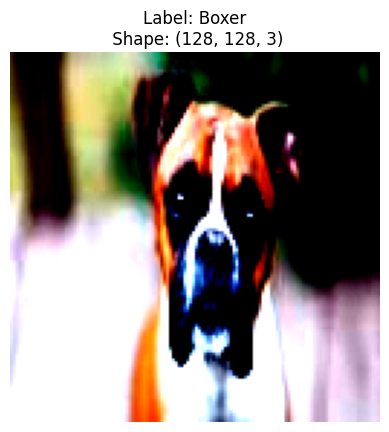

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random

index =  random.randint(0, len(data) - 1)


img, lbl = data[index]


image = img.numpy().transpose((1, 2, 0))  




plt.imshow(image)  
plt.title(f'Label: {classes[lbl]}\n Shape: {image.shape}')  
plt.axis('off') 
plt.show()


# 2 loading the data into DataLoader

In [9]:
from sklearn.model_selection import train_test_split
tensors, labels=zip(*data)
tensor=np.array([t.numpy() for t in tensors])
label=np.array([l for l in labels])
X_train, X_valid, y_train, y_valid = train_test_split(tensor, label, test_size=0.2,shuffle=True, random_state=42)

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)


train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False, drop_last=True)


for batch in train_loader:
    inputs, labels = batch
    print(inputs.shape, labels.shape)
    break  

torch.Size([32, 3, 128, 128]) torch.Size([32])


# 3 Building a model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class model_1(nn.Module):
    def __init__(self):
        super(model_1, self).__init__()
        
        self.block_1= nn.Sequential(
                        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.block_2= nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(in_features=64 * 64 * 64, out_features=128),
                        nn.Dropout(p=0.5),
                        nn.Linear(in_features=128, out_features=10)  
        )
    def forward(self, x):
            x=self.block_1(x)
            x=self.block_2(x)  
            return x


model = model_1().to(device)

print(model)

model_1(
  (block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=262144, out_features=128, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [12]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
print(f'The summary of the model.')
summary(model, input_size=[1, 3, 128, 128]) # do a test pass through of an example input size

The summary of the model.


Layer (type:depth-idx)                   Output Shape              Param #
model_1                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         448
│    └─ReLU: 2-2                         [1, 16, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 32, 128, 128]         4,640
│    └─ReLU: 2-4                         [1, 32, 128, 128]         --
│    └─Conv2d: 2-5                       [1, 64, 128, 128]         18,496
│    └─ReLU: 2-6                         [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-7                    [1, 64, 64, 64]           --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-8                      [1, 262144]               --
│    └─Linear: 2-9                       [1, 128]                  33,554,560
│    └─Dropout: 2-10                     [1, 128]                  --

# 4. defining functions like earlystopping, train_step, test_step and  train.

In [13]:
class Earlystopping:
    def __init__(self, filepath, patience=10, minimize=True):
        self.filepath=filepath
        self.paitence=patience
        self.minimize=minimize
        self.counter=0
        self.best_score=None
        self.early_stop=False
        
        if not os.path.exists(filepath):
            os.makedirs(filepath)
            print(f'file path did not exist so  {filepath} created')
        else:
            print(f'Directory exists {filepath}')
            
    def __call__(self, val_metric, model):
        
        if self.minimize:
            score=-val_metric
        else:
            score=val_metric
            
        
        if self.best_score is None:
            self.best_score=score
        elif score< self.best_score:
            self.counter+=1
            if self.counter>= self.paitence:
                print(f'Early Stopping')
                self.early_stop=True  
        else:
            self.best_score=score
            self.counter=0
            
    def save_checkpoint(self, model):
        print(f'Saving model with the current best validation metric: {self.best_score}')
        torch.save(model.state_dict(), os.path.join(self.filepath, 'checkpoint.pt'))

In [14]:
def train_step(model,dataloader, loss_fn,optimizer):
  model.train()
  train_loss, train_acc = 0, 0
  for (X,y) in dataloader:
    X,y=X.to(device),y.to(device)

    y_pred=model(X)
    loss=loss_fn(y_pred, y)
    train_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc +=(y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [15]:
def valid_step(model, dataloader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    total_loss, total_acc = 0, 0
    num_batches = len(dataloader)
    
    with torch.no_grad():  # Disable gradient calculations
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            y_pred = model(X)
            
            # Loss calculation
            loss = loss_fn(y_pred, y)  # Use logits (y_pred) and class indices (y)
            total_loss += loss.item()
            
            # Accuracy calculation
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            total_acc +=(y_pred_class == y).sum().item()/len(y_pred)  # Compute accuracy for the batch
    
    # Average loss and accuracy over all batches
    avg_loss = total_loss / num_batches
    avg_acc = total_acc / num_batches
    
    return avg_loss, avg_acc


In [16]:
from tqdm.auto import tqdm

early_stopping=Earlystopping(filepath='/kaggle/working/checkpoints',  patience=10, minimize=True)
def train(epochs,model,train_dataloader,valid_dataloader,loss_fn,optimizer):
  results={'training_loss':[],'training_acc':[],'validation_loss':[],'validation_acc':[]}

  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model,train_dataloader,loss_fn,optimizer)
    valid_loss,valid_acc=valid_step(model,valid_dataloader,loss_fn)

    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )
    results["training_loss"].append(train_loss)
    results["training_acc"].append(train_acc)
    results["validation_loss"].append(valid_loss)
    results["validation_acc"].append(valid_acc)
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        early_stopping.save_checkpoint(model)
        print(f'Early stopping triggered')
        break
    
    
  return results

Directory exists /kaggle/working/checkpoints


# 5. Model training

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
from timeit import default_timer as timer
start_time = timer()

model_results = train(model=model,
                        train_dataloader=train_loader,
                        valid_dataloader=valid_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1987 | train_acc: 0.2122 | valid_loss: 2.0421 | valid_acc: 0.3698
Epoch: 2 | train_loss: 1.7287 | train_acc: 0.4036 | valid_loss: 1.6869 | valid_acc: 0.4271
Epoch: 3 | train_loss: 1.3010 | train_acc: 0.5898 | valid_loss: 0.9707 | valid_acc: 0.7292
Epoch: 4 | train_loss: 0.8826 | train_acc: 0.7096 | valid_loss: 0.7190 | valid_acc: 0.8021
Epoch: 5 | train_loss: 0.6684 | train_acc: 0.8060 | valid_loss: 0.5975 | valid_acc: 0.8229
Epoch: 6 | train_loss: 0.5602 | train_acc: 0.8372 | valid_loss: 0.4117 | valid_acc: 0.9219
Epoch: 7 | train_loss: 0.2152 | train_acc: 0.9466 | valid_loss: 0.5103 | valid_acc: 0.8594
Epoch: 8 | train_loss: 0.1794 | train_acc: 0.9622 | valid_loss: 0.1152 | valid_acc: 0.9792
Epoch: 9 | train_loss: 0.1089 | train_acc: 0.9714 | valid_loss: 0.0750 | valid_acc: 0.9896
Epoch: 10 | train_loss: 0.1381 | train_acc: 0.9596 | valid_loss: 0.1246 | valid_acc: 0.9792
Epoch: 11 | train_loss: 0.1012 | train_acc: 0.9688 | valid_loss: 0.0915 | valid_acc: 0.98

# 6. Model testing on test_data

In [18]:
checkpoint_path = '/kaggle/working/checkpoints/checkpoint.pt'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))  # Load weights to device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [19]:
import requests
from PIL import Image
from io import BytesIO
from torchvision import transforms

def image_transform(image_url):
    
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    transform = transforms.Compose([
        transforms.Resize((128, 128)),  
        transforms.ToTensor(),          
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])

    input_tensor = transform(img)
    input_tensor = input_tensor.unsqueeze(0)  

    return input_tensor


Please insert here the link for the image

In [20]:
image_url='https://t4.ftcdn.net/jpg/00/86/67/45/360_F_86674540_3e6FWLLSXXKkjC5gwcAMy4JIPyfubCvU.jpg'

In [21]:
image=image_transform(image_url)

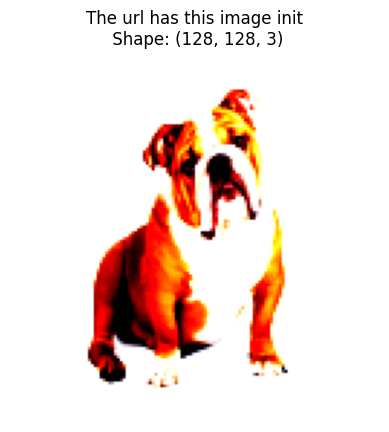

In [22]:
image_np=torch.squeeze(image, dim=0)
image_np = image_np.numpy().transpose((1, 2, 0))  


plt.imshow(image_np )  
plt.title(f'The url has this image init\n Shape: {image_np .shape}')  
plt.axis('off') 
plt.show()

In [23]:
sample = torch.unsqueeze(image, dim=0).to(device)
sample = torch.squeeze(sample, dim=1)  
sample.shape


torch.Size([1, 3, 128, 128])

In [24]:
with torch.no_grad(): 
    predictions = model(sample)
    pred_prob = torch.softmax(predictions.squeeze(), dim=0)
    pred_classes = pred_prob.argmax(dim=0)
    
print(f'The image provided contains a {classes[pred_classes]}.')

The image provided contains a Bulldog.
